In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Train chexnet model

In [2]:
from fastai.conv_learner import *
# import pixiedust
from matplotlib.patches import Rectangle
from datetime import datetime
import pandas as pd

import torch
from layers import *
from constant import *
from transform import chest_xray_transfrom
from metrics import *
import pretrainedmodels
from recorder import TrainingRecoder
import pretrainedmodels
from dataset import ChestXray14Dataset
from model_data import ModelData
from chexnet import ChexNet
from utils import get_chestxray_from_csv

In [3]:
# import from cosntant
# PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
# IMAGE_DN = 'images'
# TRAIN_CSV = 'train.csv'
# VAL_CSV = 'val.csv'
# TEST_CSV = 'test.csv'

percentage = 0.1
WORKERS = 6

N_CLASSES = 14
models_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')

model_path = PATH/'models'/models_name
model_path.mkdir(parents=True, exist_ok=True)
print('Model name', models_name)

Model name 20190131-144007


In [4]:
# the model we use not include sigmoid as last layer
def acc_s(preds, targs):
    return accuracy_multi(torch.sigmoid(preds), targs, 0.5)

def auc_s(preds, targs):
    return auc(torch.sigmoid(preds), targs)

## Load dataset

In [5]:
# def get_chestxray_from_csv():
#     result = []
#     for f in [PATH/TRAIN_CSV, PATH/VAL_CSV, PATH/TEST_CSV]:
#         df = pd.read_csv(f, sep=' ', header=None)
#         images = df.iloc[:, 0].values
#         labels = df.iloc[:, 1:].values
#         result.append((images, labels))
#     return result

def get_md(sz, bs, percentage):
    model = pretrainedmodels.__dict__['densenet121']()
    data = get_chestxray_from_csv()
    tfms = chest_xray_transfrom(model, sz, 0.875)
    datasets = ImageData.get_ds(ChestXray14Dataset, trn=data[0], val=data[1], test=data[2], tfms=tfms, path=PATH/IMAGE_DN, size=sz, percentage=percentage)
    md = ModelData(PATH/IMAGE_DN, datasets, bs, WORKERS, CLASS_NAMES)
    return md

md = get_md(224, 128, percentage)

## Densenet121 arch with binary classification

In [6]:
class CheXNetModel():
    
    def __init__(self, chexnet):
        self.model = chexnet
    
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.backbone), [8]))
        lgs += [children(self.model.head)]
        return lgs

chexnet = to_gpu(ChexNet())
chexnet_model = CheXNetModel(chexnet)
learn = ConvLearner(md, chexnet_model, models_name=model_path) # train in mixed percision
# learn.crit = WeightedBCEWithLogitsLoss()
learn.crit = nn.BCEWithLogitsLoss()

In [ ]:
### Warning ###

# Find lr for last layer groups

In [45]:
# learn.lr_find()

 89%|████████▉ | 516/577 [03:35<00:20,  2.98it/s, loss=0.648]

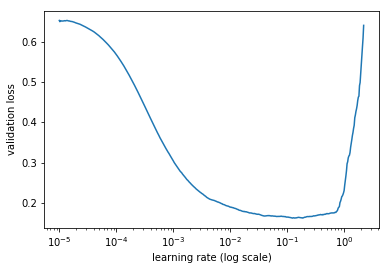

In [46]:
# learn.sched.plot(0, 0)

# Lr find for all layer group

In [47]:
# md = get_md(224, 16, percentage)
# learn.set_data(md)
# learn.unfreeze()
# learn.lr_find()

epoch      trn_loss   val_loss                                 
    0      0.181622   0.17072   


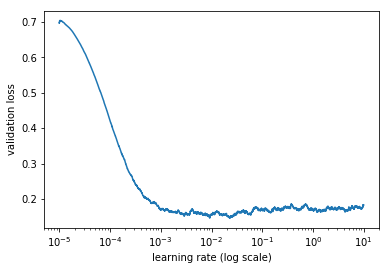

In [48]:
# learn.sched.plot(0, 0)

## Develop

In [9]:
# lr = 1e-4
# md = get_md(224, 128, percentage)
# learn.set_data(md)

In [10]:
# layer_opt = learn.get_layer_opt(lr, None)
# loss_recorder = LossRecorder(layer_opt)
# learn.sched = None
# # learn.fit_gen(learn.model, learn.data, layer_opt, 2, \
# #                   metrics=[auc_s, acc_s], cycle_len=1, use_clr=(20, 10), \
# #                   callbacks=[loss_recorder], best_save_name='best')
# learn.fit_gen(learn.model, learn.data, layer_opt, 2, use_clr=(20, 10), cycle_len=1)

 16%|█▌        | 97/614 [00:41<04:31,  1.91it/s, loss=0.544]Loss 0.4330458641052246


 31%|███▏      | 193/614 [01:19<02:09,  3.26it/s, loss=0.361]Loss 0.3003145754337311


 47%|████▋     | 289/614 [01:58<01:40,  3.23it/s, loss=0.288]Loss 0.2617330253124237


 78%|███████▊  | 480/614 [03:16<00:45,  2.97it/s, loss=0.239]Loss 0.24766398966312408


100%|█████████▉| 613/614 [04:09<00:00,  3.49it/s, loss=0.23] Loss 0.18229420483112335
epoch      trn_loss   val_loss                              
    0      0.229413   0.228297  
  9%|▉         | 57/614 [00:24<03:32,  2.63it/s, loss=0.227]Loss 0.21954041719436646


 40%|████      | 248/614 [01:41<03:01,  2.02it/s, loss=0.21] Loss 0.2043369561433792


 71%|███████▏  | 439/614 [02:58<01:33,  1.87it/s, loss=0.203]Loss 0.22161954641342163


100%|█████████▉| 613/614 [04:08<00:00,  2.89it/s, loss=0.202]Loss 0.1817658394575119
    1      0.201845   0.198444                               



[0.19844418177710718]

# Training

In [7]:
def train_last_layer(learn, loss_recorder, n_cycle, lr=1e-4):
    print(f'Train last layer group with {n_cycle} cycle, lr={lr}')
    learn.freeze_to(-1)
    md = get_md(224, 128, percentage)
    learn.set_data(md)
    layer_opt = learn.get_layer_opt(lr, None)
    loss_recorder.new_phase(layer_opt)
    learn.sched = None
    learn.fit_gen(learn.model, learn.data, layer_opt, n_cycle, \
                  metrics=[auc_s, acc_s], cycle_len=1, use_clr=(8, 10), \
                  callbacks=[loss_recorder], best_save_name='best')
    
def train_all_layer(learn, loss_recorder, n_cycle, lr=8e-3):
    print(f'Train every groups with {n_cycle} cycle, lr={lr}')
    lrs = [lr/1000, lr/100, lr]
    learn.unfreeze()
    md = get_md(224, 64, percentage)
    learn.set_data(md)
    layer_opt = learn.get_layer_opt(lrs, None)
    loss_recorder.new_phase(layer_opt)
    learn.sched = None
    learn.fit_gen(learn.model, learn.data, layer_opt, n_cycle, \
                  metrics=[auc_s, acc_s], cycle_len=1, use_clr=(8, 10), \
                  callbacks=[loss_recorder], best_save_name='best')


In [8]:
loss_recorder = TrainingRecoder(model_path)
train_last_layer(learn, loss_recorder, 1, lr=1e-4)
train_all_layer(learn, loss_recorder, 1, lr=1e-4)
# train_all_layer(learn, loss_recorder, 2, lr=8e-3) # super convergence
# train_all_layer(learn, loss_recorder, 1, lr=8e-2) # super convergence
# train_all_layer(learn, loss_recorder, 10, lr=4e-4) # slow down
# train_last_layer(learn, loss_recorder, 10, lr=4e-4) # settle down
loss_recorder.save()

Train last layer group with 1 cycle, lr=0.0001


14                                                         
epoch      trn_loss   val_loss   auc_s      acc_s      
    0      0.57349    0.53969    0.496944   0.83516   

Train every groups with 1 cycle, lr=0.0001


14                                                           
epoch      trn_loss   val_loss   auc_s      acc_s      
    0      0.390087   0.36522    0.499788   0.952976  



In [17]:
def sigmoid_np(x):
    return 1. / (1. + np.exp(-x))

print('Test')
py, y = learn.TTA()
print(auc_np(sigmoid_np(np.mean(py, axis=0)), y))

Test
0.5019808191602615                           
